# Part 1

implement methods __init__, __add__ and matvec.

In [52]:
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import csr_matrix
import numpy as np


def coo_tocsr(n_row, n_column, nnz, row, col, data, idx_dtype, dtype):
    indptr = np.zeros(n_row + 1, dtype=idx_dtype)
    indices = np.empty_like(col, dtype=idx_dtype)
    result_data = np.empty_like(data, dtype=dtype)

    for n in range(nnz):
        indptr[row[n]] += 1

    cumsum = 0
    for i in range(n_row):
        temp = indptr[i]
        indptr[i] = cumsum
        cumsum += temp
    indptr[n_row] = nnz

    for n in range(nnz):
        row_new = row[n]
        dest = indptr[row_new]
        indices[dest] = col[n]
        result_data[dest] = data[n]
        indptr[row_new] += 1

    last = 0
    for i in range(n_row + 1):
        temp = indptr[i]
        indptr[i] = last
        last = temp
    return indptr, indices, result_data


class CSRMatrix(LinearOperator):
    # takes a COO matrix as input and will initialise the CSR matrix
    def __init__(self, arg):

        self.idx_dtype = np.int32
        self.dtype = None

        self.shape = None

        self.data = None
        self.indices = None
        self.indptr = None

        if isinstance(arg, coo_matrix):
            self.init_from_COO(arg)
        else:
            self.init_from_CSR(arg)

        self.nnz = np.count_nonzero(self.data)

    def init_from_COO(self, coo):
        self.dtype = coo.dtype
        super().__init__(dtype=coo.dtype, shape=coo.shape)
        M, N = self.shape
        self.indptr, self.indices, self.data = coo_tocsr(M, N,
                                                         coo.nnz,
                                                         coo.row, coo.col, coo.data,
                                                         self.idx_dtype, self.dtype)

    def init_from_CSR(self, arg):
        self.indptr, self.indices, self.data, self.shape = arg
        super().__init__(dtype=self.data.dtype, shape=self.shape)

    def __add__(self, other: 'CSRMatrix'):
        """Add the CSR matrix other to this matrix."""
        maxnnz = self.nnz + other.nnz
        n_row, n_col = self.shape

        next = np.zeros(n_col, dtype=np.int32) - 1
        A_row = np.zeros(n_col)
        B_row = np.zeros(n_col)

        # indptr, indices, data
        # p, j, x
        Cp = np.empty_like(self.indptr, dtype=self.idx_dtype)
        Cj = np.empty(maxnnz, dtype=self.idx_dtype)
        Cx = np.empty(maxnnz, dtype=self.dtype)

        Ap = self.indptr
        Aj = self.indices
        Ax = self.data

        Bp = other.indptr
        Bj = other.indices
        Bx = other.data

        nnz = 0
        Cp[0] = 0
        for i in range(n_row):
            head = -2
            length = 0

            # add a row of A to A_row
            for jj in range(Ap[i], Ap[i + 1]):
                j = Aj[jj]
                A_row[j] += Ax[jj]
                if next[j] == -1:
                    next[j] = head
                    head = j
                    length += 1

            # add a row of B to B_row
            for jj in range(Bp[i], Bp[i + 1]):
                j = Bj[jj]
                B_row[j] += Bx[jj]
                if next[j] == -1:
                    next[j] = head
                    head = j
                    length += 1

            # scan through columns where A or B has
            # contributed a non-zero entry
            for jj in range(length):

                result = A_row[head] + B_row[head]
                if result != 0:
                    Cj[nnz] = head
                    Cx[nnz] = result
                    nnz += 1

                temp = head
                head = next[head]

                next[temp] = -1
                A_row[temp] = B_row[temp] = 0

            Cp[i + 1] = nnz

        return CSRMatrix((Cp, Cj, Cx, self.shape))

    def _matvec(self, vector):

        Ap = self.indptr
        Aj = self.indices
        Ax = self.data
        Y = np.zeros(self.shape[0], dtype=vector.dtype)
        for i in range(self.shape[0]):
            for jj in range(Ap[i], Ap[i + 1]):
                Y[i] += Ax[jj] * vector[Aj[jj]]
        return Y


Write tests to check that the __add__ and matvec methods that you have written are correct.
* These test should use appropriate assert statements.

In [53]:
from tqdm import trange


def generate_random_coo(N, nnz):
    row = np.random.randint(0, N, nnz)
    col = np.random.randint(0, N, nnz)
    data = np.random.randint(5, 22, nnz)
    return coo_matrix((data, (row, col)), shape=(N, N))


def test_add(N):
    COO_mat1 = generate_random_coo(N, N - 4)
    COO_mat2 = generate_random_coo(N, N - 2)
    my_mat1 = CSRMatrix(COO_mat1)
    my_mat2 = CSRMatrix(COO_mat2)
    my_result = my_mat2 + my_mat1
    coo_result = COO_mat1 + COO_mat2

    my_result_array = csr_matrix((my_result.data, my_result.indices, my_result.indptr),
                                 shape=my_result.shape).toarray()
    assert np.allclose(my_result_array, coo_result.toarray())


def test_product(N):
    COO_mat1 = generate_random_coo(N, N - 4)
    my_mat1 = CSRMatrix(COO_mat1)

    vector = np.random.random(N)

    my_result = my_mat1 * vector
    coo_result = COO_mat1 * vector
    array_result = np.matmul(COO_mat1.toarray(), vector)

    assert np.allclose(my_result, coo_result)
    assert np.allclose(array_result, my_result)


for N in trange(10, 300):
    test_add(N)
    test_product(N)

print('done')


100%|██████████| 290/290 [00:01<00:00, 153.44it/s]

done


measure the time taken to perform a matvec product.
measure the time taken to compute a dense matrix-vector product using Numpy.
Create a plot showing the times of matvec and Numpy for a range of matrix sizes

100%|██████████| 880/880 [00:13<00:00, 64.56it/s] 


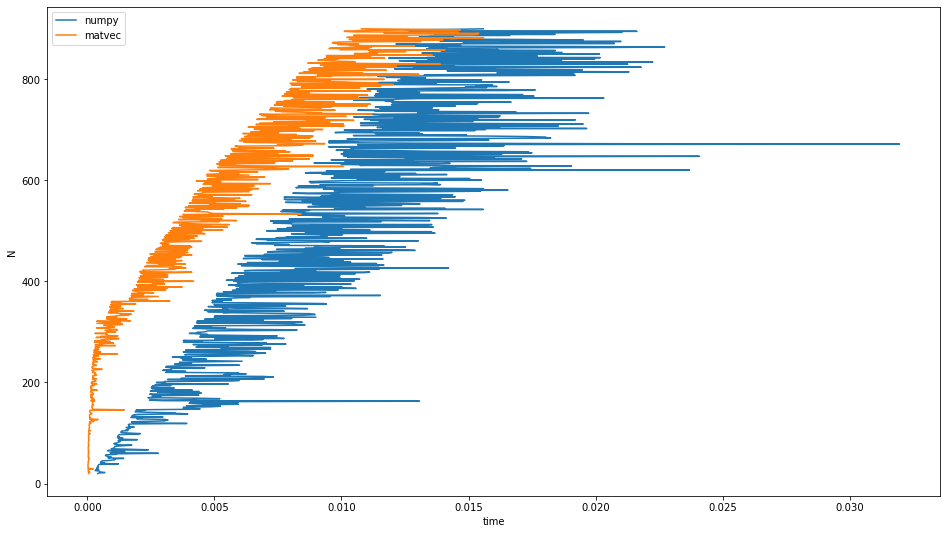

In [6]:
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm


def test_product():
    times0 = []
    times1 = []

    Ns = range(20, 900)
    repeat = 4

    for N in tqdm(Ns):
        COO_mat1 = generate_random_coo(N, N - 10)
        nparray_1 = COO_mat1.toarray()
        my_mat1 = CSRMatrix(COO_mat1)
        vector = np.random.random(N)

        t = timeit.Timer(lambda: my_mat1 * vector).timeit(repeat)
        times0.append(np.min(t))
        t = timeit.Timer(lambda: np.matmul(nparray_1, vector)).timeit(repeat)
        times1.append(np.min(t))

    plt.figure(figsize=(16, 9))
    p0, = plt.plot(times0, Ns)
    p1, = plt.plot(times1, Ns)

    plt.legend([p0, p1], ["numpy", 'matvec'], loc='upper left')
    plt.xlabel('time')
    plt.ylabel('N')
    plt.show()


test_product()

briefly (1-2 sentence) comment on what your plot shows.

use Scipy’s gmres and cg sparse solvers to solve a matrix problem using your CSR matrix.
* Check if the two solutions obtained are the same.

In [49]:
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import gmres, cg

N = 20


def generate_mat(N):
    assert N >= 0
    if N == 0: return np.array([1]), np.array([1])

    A = np.zeros([N + 1, N + 1], dtype=np.double)
    for i in range(1, N):
        A[i, i - 1:i + 2] = [-1, 2. - (29 * 29 * np.pi * np.pi / 4 / N / N), -1]
    A[0, 0] = 1
    A[N, N] = 1

    A = CSRMatrix(coo_matrix(A))

    return A, np.random.random(N + 1)


A, b = generate_mat(N)
x0, exitCode0 = gmres(A, b)
x1, exitCode1 = cg(A, b)

print(exitCode0)  # 0 indicates successful convergence
print(A.dot(x0))
print('------------')
print(exitCode1)  # 0 indicates successful convergence
print(A.dot(x1))
print('------------')
print(b)
print('------------')
print(np.allclose(A.dot(x0), b, atol=1e-5))
print(np.allclose(A.dot(x1), b, atol=1e-5))

0
[0.81356102 0.10372618 0.51195549 0.33298459 0.26354774 0.65442426
 0.99706566 0.55159687 0.40767364 0.90252664 0.9653868  0.98197972
 0.10078033 0.24914646 0.2104776  0.86045367 0.21490786 0.05674119
 0.88035433 0.66956721 0.50958892]
------------
0
[0.81356215 0.10372956 0.51195141 0.33299309 0.26354074 0.65442492
 0.99706418 0.55160058 0.40767753 0.9025311  0.96538346 0.98197765
 0.10078426 0.24914747 0.21048419 0.86045162 0.2149091  0.05673931
 0.88035706 0.66956942 0.50958963]
------------
[0.81356065 0.10372544 0.51195516 0.33298702 0.26354525 0.65442626
 0.99706578 0.55159534 0.40767274 0.90252637 0.96538339 0.98198413
 0.10077928 0.24914405 0.2104816  0.86045245 0.21490924 0.05674254
 0.88035598 0.66956512 0.50958869]
------------
True
True


"Briefly comment (1-2 sentences) on why the solutions are or are not the same.

# Part 2

Implement the Scipy LinearOperator.

In [1]:
from scipy.sparse.linalg import LinearOperator
import numpy as np


class Custom_Mat(LinearOperator):
    # takes a COO matrix as input and will initialise the CSR matrix
    def __init__(self, N, dia_mat: np.ndarray, T_mat: np.ndarray, W_mat: np.ndarray):
        assert np.allclose(T_mat.shape, [N, 2])
        assert np.allclose(W_mat.shape, [2, N])
        self.dtype = np.float64

        self.N = N
        self.dia_mat = dia_mat
        self.TW = np.matmul(T_mat, W_mat)

    @property
    def shape(self):
        return self.N * 2, self.N * 2

    def toarray(self):
        A = np.zeros(self.shape, self.dtype)
        A[:self.N, :self.N] = np.diag(self.dia_mat)
        A[self.N:, self.N:] = self.TW
        return A

    def _matvec(self, vector):
        result = np.zeros(2 * N, self.dtype)
        result[:N] = np.multiply(self.dia_mat, vector[:N])
        result[N:] = np.matmul(self.TW, vector[N:])
        return result

create matrices where the entries on the diagonal of the top-left block and in the matrices T and W are random numbers.

measure the time taken to compute matrix-vector products.
measure the time taken by Numpy to compute matrix-vector products.
Make a plot showing time taken against n.

100%|██████████| 70/70 [00:51<00:00,  1.36it/s]


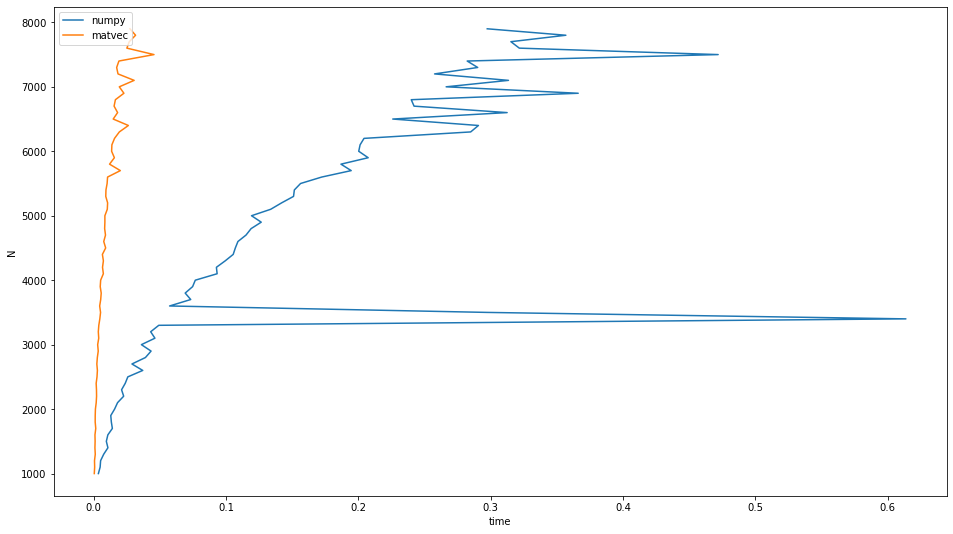

In [9]:
from tqdm import tqdm
import timeit
import matplotlib.pyplot as plt

Ns = range(1000, 8000, 100)
repeat = 1
times0 = []
times1 = []
for N in tqdm(Ns):
    T_mat = np.random.random([N, 2])
    W_mat = np.random.random([2, N])
    dia_mat = np.random.random(N)

    custom_mat = Custom_Mat(N, dia_mat, T_mat, W_mat)
    custom_array = custom_mat.toarray()
    b = np.random.random(2 * N)

    t = timeit.Timer(lambda: np.matmul(custom_array, b)).timeit(repeat)
    times0.append(np.min(t))

    t = timeit.Timer(lambda: custom_mat * b).timeit(repeat)
    times1.append(np.min(t))

    # assert np.allclose(np.matmul(custom_array, b), custom_mat * b)

plt.figure(figsize=(16, 9))
p0, = plt.plot(times0, Ns)
p1, = plt.plot(times1, Ns)

plt.legend([p0, p1], ["numpy", 'matvec'], loc='upper left')
plt.xlabel('time')
plt.ylabel('N')
plt.show()



Comment (2-4 sentences) on what your plot shows, and why you think one of these methods is faster than the other (or why they take the same amount of time if this is the case).